In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Distributions as Dist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import tqdm as tqdm

(1000000,)


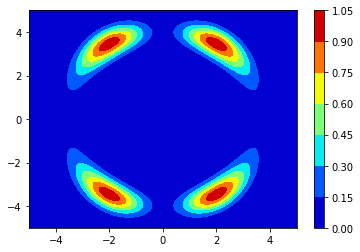

(1000000,)


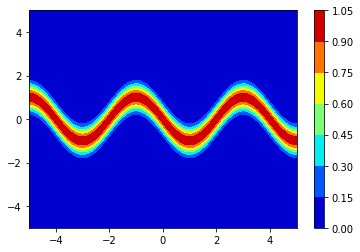

(1000000,)


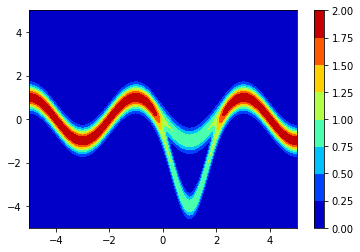

(1000000,)


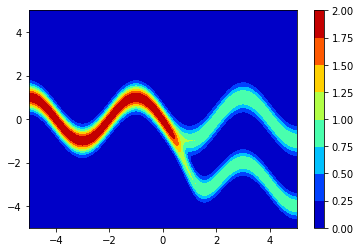

In [2]:
%matplotlib inline
X1, X2 = torch.meshgrid(torch.linspace(-5, 5, 1000), torch.linspace(-5, 5, 1000))

X = torch.stack((X1.reshape(-1), X2.reshape(-1)), dim = 1)
#print(X.size())
for i in range(1, 5, 1):
    EFunc = Dist.EnergyFunctions(i)
    Prob = EFunc.probability(X).numpy()
    print(Prob.shape)

    plt.figure()
    plt.contourf(X1.numpy(), X2.numpy(), Prob.reshape(X1.numpy().shape), cmap = plt.cm.jet)
    plt.colorbar()
    plt.show()

# Planar Flow Object

In [3]:
class PlanarFlow(nn.Module):
    def __init__(self, input_size, bias = False):
        super(PlanarFlow, self).__init__()
        
        self._w = nn.parameter.Parameter(torch.Tensor(1, input_size))
        self._u = nn.parameter.Parameter(torch.Tensor(1, input_size))
        self._b = nn.parameter.Parameter(torch.Tensor(1, input_size))
        self.initialise_parameters()
        
        self.activation = self.activ_func
        self.activation_deriv = self.activ_deriv
    
    def initialise_parameters(self, std = 0.01):
        with torch.no_grad():
            self._w.normal_(mean = 0, std = std)
            self._u.normal_(mean = 0, std = std)
            self._b.normal_(mean = 0, std = std)
    
    @staticmethod    
    def activ_func(x):
        return torch.tanh(x)

    @staticmethod
    def activ_deriv(x):
        return 1 - torch.tanh(x)**2
    
    @property
    def weight(self):
        return self._w, self._u, self._b
    
    @weight.setter
    def weight(self, std):
        print("initialising weights with sigma = {}".format(std))
        if std < 0:
            raise ExceptionError("The standard deviation you have specified here is less than zero.")
        self.initialise_parameters(std)
    
    @weight.deleter
    def weight(self, std):
        print("deleting weight matrices")
        del self._w
        del self._u
        del self._b
        
    @property
    def normalise_u(self):
        wTu = torch.matmul(self._w, self._u.t())
        wNorm = self._w / torch.norm(self._w, p = 2)
        
        m = -1 + torch.log(1 + torch.exp(wTu))
        
        adjusted_u = self._u + (m - wTu) * wNorm
        
        return adjusted_u
    
    def psi(self, z_input):
        """
        psi(z) = h(w^T . z + b) . w
        """
        return self.activation_deriv(torch.matmul(z_input, self._w.t()) + self._b) * self._w
    
    def det_dFdZ(self, z_input):
        u_norm = self.normalise_u
        
        return torch.abs(1 + torch.matmul(self.psi(z_input), u_norm.t()))
    
    def flow_pass(self, z_input):
        u_norm = self.normalise_u
        
        z_new = z_input + u_norm * self.activation(torch.matmul(z_input, self._w.t()) + self._b)
        return z_new
    
    def forward(self, tuple_input):
        """
        Take in z and return z', log (det dFdZ)
        """
        
        if isinstance(tuple_input, tuple):
            z_input = tuple_input[0]
            prev_flow = tuple_input[1]
        
        else:
            z_input = tuple_input
            prev_flow = 0
            
        z_flow = self.flow_pass(z_input)
        norm_flow = self.det_dFdZ(z_input)
        
        return z_flow, torch.log(norm_flow + 1e-8) + prev_flow

# Radial Flow Object

In [4]:
class RadialFlow(nn.Module):
    def __init__(self):
        super(RadialFlow, self).__init__()
        
        self._alpha= nn.parameter.Parameter(torch.Tensor(1, 1))
        self._beta = nn.parameter.Parameter(torch.Tensor(1, 1))
        self.initialise_parameters()
    
    def initialise_parameters(self, std = 0.01):
        with torch.no_grad():
            self._alpha.uniform_()
            self._beta.normal_(mean = 0, std = std)
            
    @property
    def constrain_beta(self):
        m = torch.log(1 + torch.exp(self._beta))
        return -1 * self._alpha + m
    
    @staticmethod
    def radius(z_input, z_0):
        return torch.norm(z_input - z_0)
    
    def h(self, z_input, z_0):
        return 1 / (self._alpha + self.radius(z_input, z_0))
    
    def h_prime(self, z_input, z_0):
        return -1 / (self._alpha + self.radius(z_input, z_0)).pow(2)
        
    @property
    def weight(self):
        return self._alpha, self._beta
    
    @weight.setter
    def weight(self, std):
        print("initialising weights with sigma = {}".format(std))
        if std < 0:
            raise ExceptionError("The standard deviation you have specified here is less than zero.")
        self.initialise_parameters(std)
    
    @weight.deleter
    def weight(self, std):
        print("deleting weight matrices")
        del self._alpha
        del self._beta
        
    def det_dFdZ(self, z_input, z_0):
        d = z_input.size()[1]
        
        beta = self.constrain_beta
        radius = self.radius(z_input, z_0)
        
        gamma = 1 + beta * self.h(z_input, z_0)
        
        return (gamma ** (d - 1)) * (gamma + beta * self.h_prime(z_input, z_0) * radius)
    
    def flow_pass(self, z_input, z_0):
        
        beta = self.constrain_beta
        z_new = z_input + beta * self.h(z_input, z_0) * (z_input - z_0)
        
        return z_new
    
    def forward(self, tuple_input):
        """
        Take in z and return z', log (det dFdZ)
        """
        #print(len(tuple_input))

        if isinstance(tuple_input, tuple):
            z_input = tuple_input[0]
            prev_flow = tuple_input[1]
        
        else:
            z_input = tuple_input
            prev_flow = 0
        
        z_0 = torch.zeros_like(z_input).requires_grad_(False)
        
        z_flow = self.flow_pass(z_input, z_0)
        norm_flow = self.det_dFdZ(z_input, z_0)
        
        return z_flow, torch.log(norm_flow + 1e-8) + prev_flow

# Real Non-Volume Preserving Flow

In [5]:
class RNVPLinear(nn.Module):
  #Allows one to define the complex scale function for real nvp
  #REMEMBER - only square matrices are invertible and ReLU cannot be inverted. Use TanH as analytical inverse is known
  def __init__(self, in_features, out_features, bias = True, activation_end = False):
    super(RNVPLinear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.activation_end_flag = activation_end

    self.flow1 = nn.Linear(self.in_features, 256, bias = True) #bias = True is important... however I am unsure as to how invertibility is kept
    self.flow2 = nn.Linear(256, 256, bias = True)
    self.flow3 = nn.Linear(256, 256, bias = True)
    self.flow4 = nn.Linear(256, self.out_features, bias = True)
    self.normal_init()
    self.activation = nn.LeakyReLU()

  def normal_init(self):
    """
    with torch.no_grad():
      nn.init.normal_(self.flow1.weight, mean = 0, std = 0.01)
      nn.init.normal_(self.flow2.weight, mean = 0, std = 0.01)
      nn.init.normal_(self.flow3.weight, mean = 0, std = 0.01)
      nn.init.normal_(self.flow4.weight, mean = 0, std = 0.01)

      self.flow1.bias.data.fill_(0.01)
      self.flow2.bias.data.fill_(0.01)
      self.flow3.bias.data.fill_(0.01)
      self.flow4.bias.data.fill_(0.01)
    """
    pass

  def forward(self, x): #return zk
    z = self.activation(self.flow1(x))
    z = self.activation(self.flow2(z))
    z = self.activation(self.flow3(z))

    if self.activation_end_flag:
      z = F.softplus(self.flow4(z))
    else:
      z = self.flow4(z)

    return z
  
class RNVPFlow(nn.Module):
  def __init__(self, input_size, input_kept, reverse_flag = False):
    """
    input_size = number of input dimensions
    input_kept = number of input dimensions that are not perturbed (from 0)
    reverse = False - an indicator to swap the unchanged indices
    not a complex version, could be made more complex if required
    """
    super(RNVPFlow, self).__init__()
    self.input_size = input_size
    self.input_kept = input_kept
    self.reverse_flag = reverse_flag

    self.mask = nn.parameter.Parameter(torch.zeros(1, self.input_size), requires_grad = False)

    self.Scale = RNVPLinear(in_features = self.input_size, out_features = self.input_size, bias = True, activation_end = False)
    self.Transform = RNVPLinear(in_features = self.input_size, out_features = self.input_size, bias = True, activation_end = False)

    self.initialise_mask()
  
  def initialise_mask(self):
      with torch.no_grad():
          if self.reverse_flag:
            self.mask[0, self.input_kept:] = 1
          
          else:
            self.mask[0, :self.input_kept] = 1
  
  def forward(self, z):
    
    if isinstance(z, tuple):
      z_input = z[0]
      prev_log_det = z[1]
    
    else:
      z_input = z
      prev_log_det = 0

    #RNVP
    scale = self.Scale(z_input * self.mask)
    trans = self.Transform(z_input * self.mask)
    
    zk = (z_input * self.mask) + (z_input * torch.exp(scale) + trans)  * (1 - self.mask)

    log_det = torch.sum(scale * (1 - self.mask), dim = 1)

    return zk, log_det + prev_log_det

  def inverse(self, z):
    if isinstance(z, tuple):
      z_k = z[0]
      prev_log_det = z[1]
    
    else:
      z_k = z
      prev_log_det = 0

    #RNVP inverse
    scale = self.Scale(z_k * self.mask)
    trans = self.Transform(z_k * self.mask)
    
    z_out = (self.mask * z_k) + (z_k - trans) * torch.exp(-1 * scale) * (1 - self.mask)
    log_det = -1 * torch.sum(scale * (1 - self.mask), dim = 1)

    return z_out, log_det + prev_log_det
"""
Test4 = RNVPFlow(2, 1, reverse_flag= False)
print(Test4.mask, '\n')

#the last column of a should change and then reverse (reverse_flag = False) opposite for reverse_flag = True
#with torch.no_grad():
a = torch.rand(10, 2)
print(a)
out = Test4(a)
#print(out)
print(out[0], "\n", out[1], '\n', torch.sum(out[1]), "\n\n")
out1 = Test4.inverse(out[0])
print(out1)
"""



'\nTest4 = RNVPFlow(2, 1, reverse_flag= False)\nprint(Test4.mask, \'\n\')\n\n#the last column of a should change and then reverse (reverse_flag = False) opposite for reverse_flag = True\n#with torch.no_grad():\na = torch.rand(10, 2)\nprint(a)\nout = Test4(a)\n#print(out)\nprint(out[0], "\n", out[1], \'\n\', torch.sum(out[1]), "\n\n")\nout1 = Test4.inverse(out[0])\nprint(out1)\n'

# Pytorch Network object and Objective Function

In [6]:
class FlowNetwork(nn.Module):
    def __init__(self, latent_size, num_flows, flow_type = "planar", parametric_prior = False, out_lims = False):
        super(FlowNetwork, self).__init__()
        
        self.latent_size = latent_size
        self.num_flows = num_flows
        self.out_lims = out_lims #limits the range of outputs as I think this is causing crazy gradients

        if self.out_lims:
          self.s = 6

        self.flow_type = flow_type
        self.device = torch.device("cpu" if torch.cuda.is_available else "cpu")

        self.gaussian_mu = nn.Parameter(torch.randn(1, latent_size).normal_(0, 0.01), requires_grad = parametric_prior)
        self.gaussian_log_var = nn.Parameter(torch.rand(1, latent_size).normal_(0, 0.01), requires_grad = parametric_prior)
        
        if flow_type.lower() == "planar":
            self.flow_layer = nn.Sequential(*[PlanarFlow(self.latent_size) for i in range(self.num_flows)])
            print("Made a planar flow {} layer NN.".format(self.num_flows))
            
        elif flow_type.lower() == "radial":
            self.flow_layer = nn.Sequential(*[RadialFlow() for i in range(self.num_flows)])
            print("Made a radial flow {} layer NN.".format(self.num_flows))
        
        elif flow_type.lower() == "r_nvp":
          self.flow_layer = nn.Sequential(*[RNVPFlow(self.latent_size, int(self.latent_size/2), reverse_flag = bool(i % 2)) for i in range(self.num_flows)])
          print("Made a Real-NVP flow {} layer NN.".format(self.num_flows))
        
    def sample_noise(self, batch_size):
        with torch.no_grad():
            eps = torch.randn(batch_size, self.latent_size).to(self.device)
            
        std = torch.sqrt(torch.exp(self.gaussian_log_var))
        return self.gaussian_mu + eps * std

    def forward(self, batch_size = 512, input_sample = None):
        if input_sample is None:
          input_sample = self.sample_noise(batch_size).to(self.device)

        flow_out = self.flow_layer(input_sample)
        
        if self.out_lims:
          tanh_der = 1 - torch.tanh(flow_out[0])**2
          log_abs_det = flow_out[1] + torch.sum(torch.log(torch.abs(self.s * tanh_der)), dim = 1)

          zk = self.s * torch.tanh(flow_out[0])
        
        else:
          zk = flow_out[0]
          log_abs_det = flow_out[1]

        return input_sample, zk, log_abs_det, self.gaussian_mu, self.gaussian_log_var
    
    def inverse(self, z_input):
      log_det0 = 0

      if self.out_lims:
        #Can either just take 1/(dz_i+1/dz_i) or use actual inverse. 
        #tanh_der = 1 - torch.tanh(z_input)**2
        #log_det0 += -1 * torch.sum(torch.log(torch.abs(tanh_der)), dim = 1)
        inv_tanh_deriv = (1 - (z_input/self.s)**2 + 1e-8) / self.s
        log_det0 = torch.sum(torch.log(torch.abs(inv_tanh_deriv) + 1e-8), dim = 1)

        z_input = 0.5 * torch.log((1 + z_input/self.s) / (1 - z_input/self.s + 1e-8) + 1e-8)

        z_input = (z_input, log_det0)

      for i in range(self.num_flows- 1, -1, -1):
        z_input = self.flow_layer[i].inverse(z_input)
      
      return z_input[0], z_input[1] #transformed back sample and log_det_J
 
class ModularGaussian(nn.Module):
    def __init__(self):
        super(ModularGaussian, self).__init__()
    
    def forward(self, mean, variance, prediction):
        #equivalent to using torch.distributions.MultivariateNormal().log_prob(Z)
        
        if mean.size()[0] == 1:
            #need to extend it
            mean = mean.repeat(prediction.size()[0], 1)
            
        D = mean.size()[1]#Just simple case for a batch
        
        constant = D/2 * np.log(2 * np.pi)
        
        error = mean - prediction
        squared_loss =  torch.sum(torch.mul(error.pow(2), 1/(2 * variance + 1e-8)), dim = 1)
        
        log_var = torch.log(variance + 1e-8)  
        log_var_det = 1/2 * torch.sum(log_var, dim = 1)
        
        log_gauss = -1 * (squared_loss + log_var_det + constant).view(-1, 1)

        return log_gauss

class FlowObjective(nn.Module):
    def __init__(self, data_distribution, input_size, prior = 'unit_gaussian'):
        super(FlowObjective, self).__init__()
        
        self.output_dist = data_distribution 
        self.log_gaussian = ModularGaussian()
        
        #Add in other prior distributions if necessary
        if prior.lower() == 'unit_gaussian':
            self.prior_mean = torch.zeros((1, input_size))
            self.prior_var = torch.ones((1, input_size))
            
        else:
            raise SystemExit("You need to define the prior distribution.")
        
        self.t = 1
    
    def AnnealSchedule(self):
        self.Beta = 1#min(1, 0.01 + self.t/10000)
        self.t += 1
        
    def forward(self, z_0, z_k, log_det, mu, log_var):
        
        self.AnnealSchedule()
        #log qz0 - likelihood of z0 under parametrised distribution
        logq_z0 = self.log_gaussian(mu, torch.exp(log_var), z_0)
        
        #log p_z0 - likelihood of z0 under prior distribution
        logp_z0 = self.log_gaussian(self.prior_mean, self.prior_var, z_0)
        
        #logp_z - likelihood of p(x|z) from sample pushed through flow 
        logpx_z = self.Beta * torch.log(self.output_dist.probability(z_k) + 1e-8)

        cost =  logq_z0 - (logpx_z + logp_z0 + log_det)
        
        return cost.mean()

class ForwardKLDivergence(nn.Module):
  def __init__(self, input_size, prior = 'unit_gaussian'):
    super(ForwardKLDivergence, self).__init__()
    #This is the case where you have samples from x and wish to train f^-1 by evaluating point under p(z) - prior

    if prior.lower() == 'unit_gaussian':
      self.prior_mean = torch.zeros((1, input_size))
      self.prior_var = torch.ones((1, input_size)) 
    
    self.log_gaussian = ModularGaussian()

  def forward(self, z_1, log_det):
    pz_z1 = self.log_gaussian(self.prior_mean, self.prior_var, z_1)
    cost = -1 * (pz_z1 + log_det)

    return cost.mean()

class ReverseKLDivergence(nn.Module):
    def __init__(self, data_distribution, input_size, prior = 'unit_gaussian'):
        super(ReverseKLDivergence, self).__init__()
        
        self.output_dist = data_distribution 
        self.log_gaussian = ModularGaussian()
        
        #Add in other prior distributions if necessary
        if prior.lower() == 'unit_gaussian':
            self.prior_mean = torch.zeros((1, input_size))
            self.prior_var = torch.ones((1, input_size))
            
        else:
            raise SystemExit("You need to define the prior distribution.")
        
        self.t = 1
    
    def AnnealSchedule(self):
        self.Beta = 1#min(1, 0.01 + self.t/10000)
        self.t += 1
        
    def forward(self, z_0, z_k, log_det, mu, log_var):
        
        self.AnnealSchedule()
        #log qz0 - likelihood of z0 under parametrised distribution
        logq_z0 = self.log_gaussian(mu, torch.exp(log_var), z_0)
        
        #logp_z - likelihood of p(x|z) from sample pushed through flow 
        logpx_z = self.Beta * torch.log(self.output_dist.probability(z_k) + 1e-8)
        
        #print(logq_z0, logp_z0, logpx_z)

        cost =  logq_z0 - (logpx_z + log_det)
        
        return cost.mean()

# Train the flow!

Made a Real-NVP flow 8 layer NN.

Using reverse (KL) mapping as you have samples from p(x).

Epoch 0: 2.5217
Epoch 500: 0.6931
Epoch 1000: 0.3719
Epoch 1500: 0.2130
Epoch 2000: 0.4998
Epoch 2500: 0.2701
Epoch 3000: 0.3479
Epoch 3500: 0.2859
Epoch 4000: 0.3339
Epoch 4500: 0.4042
Epoch 5000: 0.2639
Epoch 5500: 0.4602
Epoch 6000: 0.2625
Epoch 6500: 0.3089
Epoch 7000: 0.3454
Epoch 7500: 0.4453
Epoch 8000: 0.3661
Epoch 8500: 0.3139
Epoch 9000: 0.3813
Epoch 9500: 0.3704
Done!


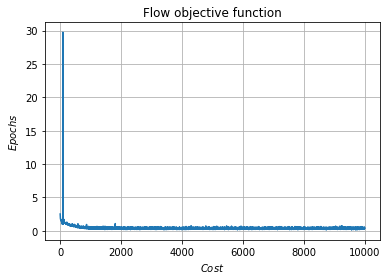

In [37]:
%matplotlib inline

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

#########################################
#PROPERTIES
#########################################
input_size = 2
num_flows = 8
flow_type = "r_nvp"
type_cost = 'forward'
limit_out = False
energy_function = Dist.EnergyFunctions(4)

batch_size = 100
epochs = 10000
learning_rate = 1e-4
#########################################

#Define instance
flow = FlowNetwork(input_size, num_flows, flow_type = flow_type, out_lims = limit_out)

device = torch.device("cpu" if torch.cuda.is_available else "cpu") #just default it to cpu
flow.to(device)

#Define objective function
if type_cost.lower() == 'standard': #you have p(x) and can readily evaluate likelihood of samples
  print("\nUsing forward mapping as you have p(x).\n")
  Cost = FlowObjective(energy_function, input_size)

elif type_cost.lower() == 'forward': #you have samples and perform reverse direction
  print("\nUsing reverse (KL) mapping as you have samples from p(x).\n")
  Cost = ForwardKLDivergence(input_size)

elif type_cost.lower() == 'reverse': #you have p(x) and can readily evaluate likelihood of samples
  print("\nUsing forward (KL) mapping as you have p(x).\n")
  Cost = ReverseKLDivergence(energy_function, input_size)

optim = torch.optim.Adam(flow.parameters(), lr = learning_rate)

cost_list = []
for i in range(epochs):
  if type_cost.lower() == "standard" or type_cost.lower() == "reverse":
      out_model = flow(batch_size = batch_size)
      loss = Cost(*out_model)
  
  elif type_cost.lower() == "forward":
    zk = datasets.make_moons(n_samples = batch_size, noise=.05)[0].astype(np.float32)
    out_model = flow.inverse(torch.from_numpy(zk))
    loss = Cost(*out_model)

  loss.backward()
  optim.step()
  optim.zero_grad()
  
  cost_list.append(loss.item())

  if (i) % 500 == 0:
    print("Epoch {}: {:.4f}".format(i, loss.item()))

print("Done!")

plt.figure()
plt.title("Flow objective function")
plt.plot(cost_list)
plt.grid()
plt.xlabel(r"$Cost$")
plt.ylabel(r"$Epochs$")
plt.show()


# Visualise the flow!

Optimised q(z) parameters:
Parameter containing:
tensor([[-0.0106,  0.0155]])
tensor([[1.0052, 0.0000],
        [0.0000, 0.9869]])


torch.Size([100000, 2])


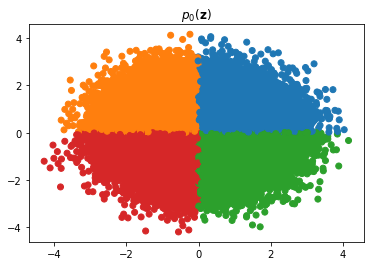

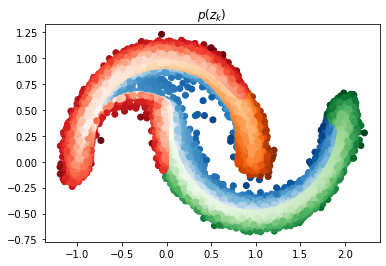

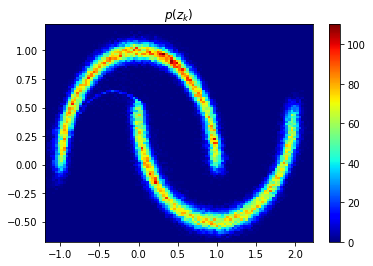

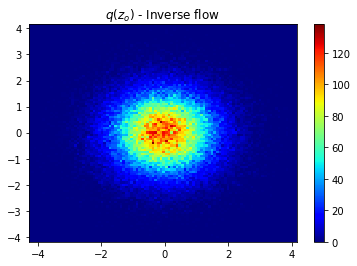

In [38]:
%matplotlib inline
print("Optimised q(z) parameters:")
print(flow.gaussian_mu)
print(torch.diag(torch.exp(flow.gaussian_log_var[0, :])))
print("\n")

no_samples = 100000
dist = torch.distributions.MultivariateNormal(flow.gaussian_mu[0, :], torch.diag(torch.exp(flow.gaussian_log_var[0, :])))
latent_samples = dist.sample((no_samples, )).to(device)
print(latent_samples.shape)

c = []
r = ([], [], [], [])
index = ([], [], [], [])
for i in range(no_samples):
    if latent_samples[i, 0] > flow.gaussian_mu[0, 0] and latent_samples[i, 1] > flow.gaussian_mu[0, 1]:
        c.append('C0')
        r[0].append(torch.norm(latent_samples[i, :], p = 2))
        index[0].append(i)
    
    if latent_samples[i, 0] <= flow.gaussian_mu[0, 0] and latent_samples[i, 1] > flow.gaussian_mu[0, 1]:
        c.append('C1')
        r[1].append(torch.norm(latent_samples[i, :], p = 2))
        index[1].append(i)
        
    if latent_samples[i, 0] > flow.gaussian_mu[0, 0] and latent_samples[i, 1] <= flow.gaussian_mu[0, 1]:
        c.append('C2')
        r[2].append(torch.norm(latent_samples[i, :], p = 2))
        index[2].append(i)
        
    if latent_samples[i, 0] <= flow.gaussian_mu[0, 0] and latent_samples[i, 1] <= flow.gaussian_mu[0, 1]:
        c.append('C3')
        r[3].append(torch.norm(latent_samples[i, :], p = 2))
        index[3].append(i)

out = torch.zeros(no_samples, input_size)
inverse_flow = torch.zeros(no_samples, input_size)

for i in range(0, no_samples + 512, 512):
  with torch.no_grad():
    lower = i
    upper = min(lower + 512, no_samples)
    out[lower:upper, :] = flow(input_sample = latent_samples[lower:upper, :])[1]

    if flow_type.lower() == 'r_nvp':
      inverse_flow[lower:upper, :] = flow.inverse(out[lower:upper, :])[0]

out = out.numpy()
inverse_flow = inverse_flow.numpy() 

plt.figure()
plt.title("$p_0(\mathbf{z})$")
plt.scatter(latent_samples.cpu().numpy()[:, 0], latent_samples.cpu().numpy()[:, 1], color = c)
plt.show()

plt.figure()
plt.title(r"$p(z_k)$")
plt.scatter(out[index[0], 0], out[index[0], 1], c = r[0], cmap = plt.cm.Blues)
plt.scatter(out[index[1], 0], out[index[1], 1], c = r[1], cmap = plt.cm.Oranges)
plt.scatter(out[index[2], 0], out[index[2], 1], c = r[2], cmap = plt.cm.Greens)
plt.scatter(out[index[3], 0], out[index[3], 1], c = r[3], cmap = plt.cm.Reds)
plt.show()

plt.figure()
plt.title(r"$p(z_k)$")
plt.hist2d(out[:, 0], out[:, 1], bins=100, cmap='jet')
plt.colorbar()
plt.show()



if flow_type.lower() == 'r_nvp':
  """
#TODO Showcase how Real NVP can get probabilities using p_z(F^-1(x))*det where x is generated from a grid of points
#logp(x) = log[p_z(F^-1(x))] + log[det dfi/dz_i+1]

X1, X2 = torch.meshgrid(torch.linspace(-5, 5, 1000), torch.linspace(-5, 5, 1000))

X = torch.stack((X1.reshape(-1), X2.reshape(-1)), dim = 1)
Prob = torch.zeros(X.size()[0], 1)

LogGauss = ModularGaussian()#initialise log calculation

for i in range(0, no_samples + 512, 512):
  with torch.no_grad():
    lower = i
    upper = min(lower + 512, no_samples)
    flow_back = flow.inverse(input_sample = X[lower:upper, :])
    log_px = LogGauss(torch.zeros(2), torch.ones(2), flow_back[0])
    Prob[lower:upper, 0] = log_px + flow_back[1]

Prob = Prob.numpy()

plt.figure()
plt.title(r"$p(z_k)$ - Contour")
plt.contour(X1.numpy(), X2.numpy(), Prob.reshape(X1.numpy().shape), levels = 50, cmap = plt.cm.jet)
plt.show()
  """

  plt.figure()
  plt.title(r"$q(z_o)$ - Inverse flow")
  plt.hist2d(inverse_flow[:, 0], inverse_flow[:, 1], bins=100, cmap='jet')
  plt.colorbar()
  plt.show()

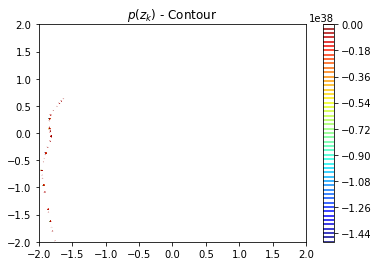

In [39]:
#TODO Showcase how Real NVP can get probabilities using p_z(F^-1(x))*det where x is generated from a grid of points
#logp(x) = log[p_z(F^-1(x))] + log[det dfi/dz_i+1]

with torch.no_grad():
  X1, X2 = torch.meshgrid(torch.linspace(-2, 2, 1000), torch.linspace(-2, 2, 1000))

  X = torch.stack((X1.reshape(-1), X2.reshape(-1)), dim = 1)
  Prob = torch.zeros(X.size()[0], 1)

  LogGauss = ModularGaussian()#initialise log calculation

  for i in range(0, no_samples + 512, 512):
    with torch.no_grad():
      lower = i
      upper = min(lower + 512, no_samples)
      flow_back = flow.inverse(X[lower:upper, :])
      log_px = LogGauss(torch.zeros(1, 2), torch.ones(1, 2), flow_back[0])
      Prob[lower:upper, :] = log_px.reshape(-1, 1) + flow_back[1].reshape(-1, 1)

  Prob = Prob.numpy()

  for i in range(len(Prob)):
    if Prob[i, 0] == float('inf') or Prob[i, 0] == float('nan'):
      Prob[i, 0] = 0

  plt.figure()
  plt.title(r"$p(z_k)$ - Contour")
  plt.contour(X1.numpy(), X2.numpy(), Prob.reshape(X1.numpy().shape), levels = 50, cmap = plt.cm.jet)
  plt.colorbar()
  plt.show()

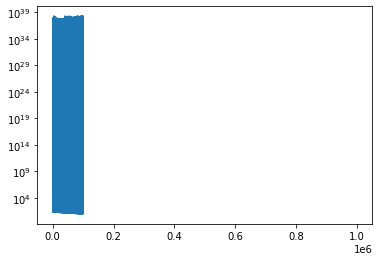

In [34]:
plt.figure()
plt.semilogy(-1 * Prob[:, 0])
plt.show()

In [ ]:
zk = torch.from_numpy(datasets.make_moons(n_samples = 10000, noise=.05)[0].astype(np.float32))
with torch.no_grad():
  inverse1 = flow.inverse(zk)[0].numpy()


plt.figure()
plt.scatter(zk[:, 0], zk[:, 1])
plt.show()

plt.figure()
plt.scatter(inverse1[:, 0], inverse1[:, 1])
plt.show()